In [1]:
# import libraries 
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import matplotlib.patches as mpatches
import seaborn as sns
#import racplusplus
import pickle
from scipy.cluster import hierarchy

from scipy.cluster.hierarchy import dendrogram, fcluster
from sklearn.cluster import AgglomerativeClustering
from clusteval import clusteval

In [34]:
my_colors = ['#88292F', '#697268', '#12355B', '#D7816A']
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', my_colors)

my_colors_2 = ['#88292F', '#697268', '#12355B', '#D7816A', '#e8da6f', '#c33b43', 
               '#9DBF9E', '#64a0e0', '#343934', '#280003','#cd5a61', '#913d27', 
               '#F46036', '#248232',  '#bea602', '#0a6682', '#646536', '#624763', '#2F1847', 
               '#FF7B9C', '#66A182', '#94849B', '#ACD8AA', '#F48498', '#B30089']
custom_cmap_2 = LinearSegmentedColormap.from_list('custom_cmap_2', my_colors_2)

In [28]:
pca_df = pd.read_csv('pca_df.csv')
df_subset = pd.read_csv('df_subset.csv')

# Hierarchical clustering

## Aglomerative

### Single Link

[clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[single]
[clusteval] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|██████████| 23/23 [10:06<00:00, 26.37s/it]
[clusteval] >INFO> Compute dendrogram threshold.
[clusteval] >INFO> Optimal number clusters detected: [2].
[clusteval] >INFO> Fin.


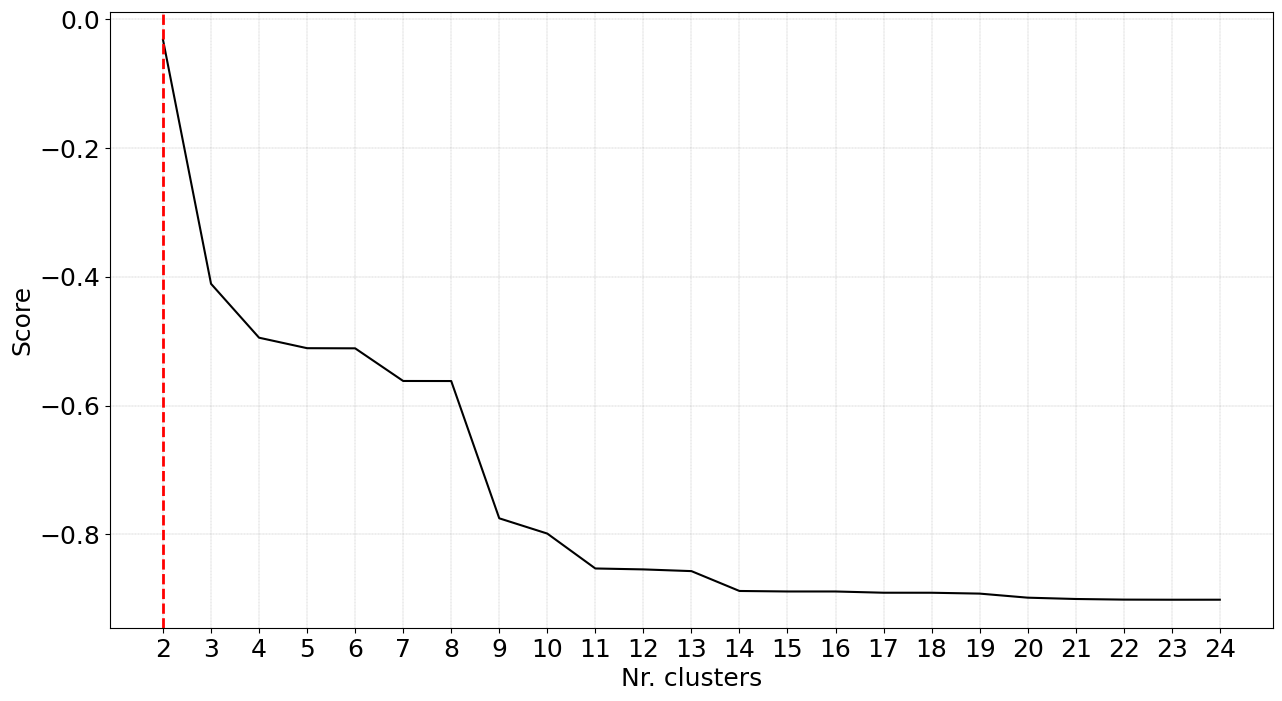

(<Figure size 1500x800 with 1 Axes>,
 <Axes: xlabel='Nr. clusters', ylabel='Score'>)

In [4]:
# Initialize
ce = clusteval(linkage= 'single', evaluate='silhouette')

# Fit
ce.fit(pca_df)

# Plot
ce.plot()

In [6]:
# Plot dendrogram
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)
    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [79]:
with open('results_pca/hierarchical/single_clustering.pickle', 'rb') as f:
    model_single = pickle.load(f)

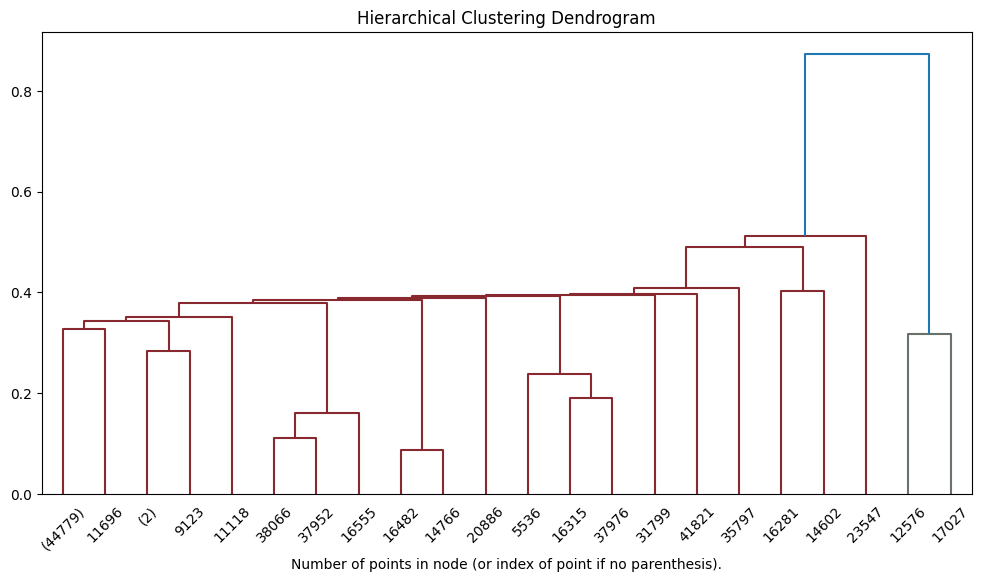

In [45]:
hierarchy.set_link_color_palette(my_colors)

plt.figure(figsize=(12, 6))
plt.title('Hierarchical Clustering Dendrogram')
# Plot the dendrogram
plot_dendrogram(model_single, truncate_mode='level', p = 12)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [80]:
# Cut dendrogram to obtain labels
num_clusters = 2  

# Convert the children_ attribute to a scipy hierarchical tree
linkage_matrix = np.column_stack([model_single.children_, model_single.distances_,
                                  np.ones_like(model_single.distances_)])
# Cut the tree to obtain labels
labels_cut = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

print(labels_cut)

[1 1 1 ... 1 1 1]


In [81]:
len(np.unique(labels_cut))

2

In [82]:
pca_df = pca_df.loc[:,'PC1':'PC2']
df_subset = df_subset.loc[:,'asset_id':'farm']

In [83]:
# Assign the cluster labels to the original DataFrame
pca_df['cluster_label'] = labels_cut
pca_df['asset_id'] = df_subset['asset_id']

In [84]:
df_subset['cluster_label'] = labels_cut

In [85]:
df_subset.to_csv('results_pca/hierarchical_opt/csv_labels_cut_raw/single_link.csv', index= False)

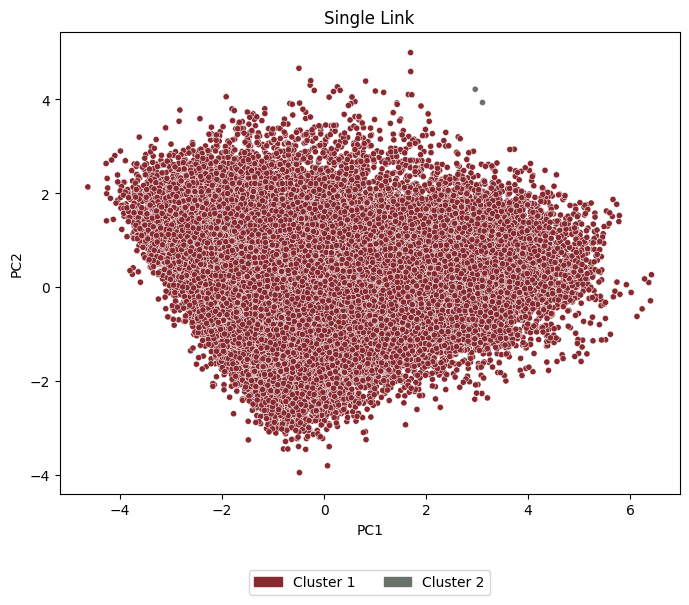

In [35]:
n_clusters = len(pca_df['cluster_label'].unique())
pallete = sns.color_palette(my_colors_2, n_clusters)

# Plot the representative points on a scatter plot using PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster_label', palette=pallete, s=20)
plt.title('Single Link')
plt.xlabel('PC1')
plt.ylabel('PC2')
legend_handles = [mpatches.Circle((0, 0), radius=1, color=color) for color in my_colors_2]
plt.legend(handles=legend_handles, labels=[f'Cluster {cluster_label}' for cluster_label in np.unique(labels_cut)],
           loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5)
plt.show()

In [87]:
most_frequent_clusters = pca_df.groupby('asset_id')['cluster_label'].agg(lambda x: np.bincount(x).argmax())

# Merge the most frequent cluster labels back to the original DataFrame
df_subset = df_subset.drop(columns='cluster_label')

df_subset = pd.merge(df_subset, most_frequent_clusters, on='asset_id', how='left')

df_subset.head()

,asset_id,read_at,wind_speed,wind_direction,power_average,rotation_average,exterior_temperature,nacelle_temperature,farm,cluster_label
0,11,1641199200,3.8,227.0,80.0,8.41,12.0,21.0,1,1
1,11,1614628200,5.2,231.0,165.0,9.93,5.0,20.0,1,1
2,11,1636269600,8.6,61.0,1013.0,16.26,7.0,12.0,1,1
3,11,1646093400,3.4,245.0,45.0,7.44,7.0,21.0,1,1
4,11,1613958000,7.0,271.0,571.0,14.35,0.0,12.0,1,1


In [88]:
len(most_frequent_clusters.unique())

1

In [89]:
pca_df = pca_df.drop(columns='cluster_label')

pca_df = pd.merge(pca_df, most_frequent_clusters, on='asset_id', how='left')

pca_df.head()

,PC1,PC2,asset_id,cluster_label
0,-1.253143,-0.763049,11,1
1,-0.374977,-1.197599,11,1
2,1.976068,-0.386187,11,1
3,-1.228114,-1.370854,11,1
4,1.454437,-1.465956,11,1


In [90]:
representative_points = pca_df.groupby(['asset_id']).first().reset_index()
representative_points

,asset_id,PC1,PC2,cluster_label
0,11,-1.253143,-0.763049,1
1,12,-3.048094,0.908466,1
2,13,-2.296033,-0.692692,1
3,14,4.322358,0.855529,1
4,15,-3.222389,1.460962,1
...,...,...,...,...
66,414,-1.996917,-1.151260,1
67,415,-0.195303,-1.531435,1
68,510,-1.418674,0.145497,1
69,511,1.187020,0.759987,1


In [91]:
assets_clusters = representative_points.groupby('cluster_label')['asset_id']

# Print assets in each cluster
for cluster, assets in assets_clusters:
    print(f"Cluster {cluster}: {assets.index.tolist()}")

Cluster 1: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70]


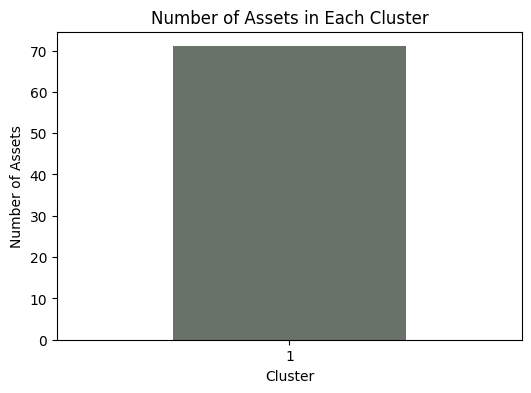

In [92]:
# Group assets by cluster and count the number of assets in each cluster
cluster_counts = representative_points['cluster_label'].value_counts().sort_index()

# Plot the number of assets in each cluster
plt.figure(figsize=(6, 4))
cluster_counts.plot(kind='bar', color=my_colors[1])
plt.xlabel('Cluster')
plt.ylabel('Number of Assets')
plt.title('Number of Assets in Each Cluster')
plt.xticks(rotation=0)
plt.show()

In [93]:
df_subset.to_csv('results_pca/hierarchical_opt/labels_most_common/single_link.csv', index= False)

In [94]:
df_subset = df_subset.loc[:,:'farm']
pca_df = pca_df.loc[:,:'PC2']

### Average Link

[clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[average]
[clusteval] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|██████████| 23/23 [08:55<00:00, 23.27s/it]
[clusteval] >INFO> Compute dendrogram threshold.
[clusteval] >INFO> Optimal number clusters detected: [2].
[clusteval] >INFO> Fin.


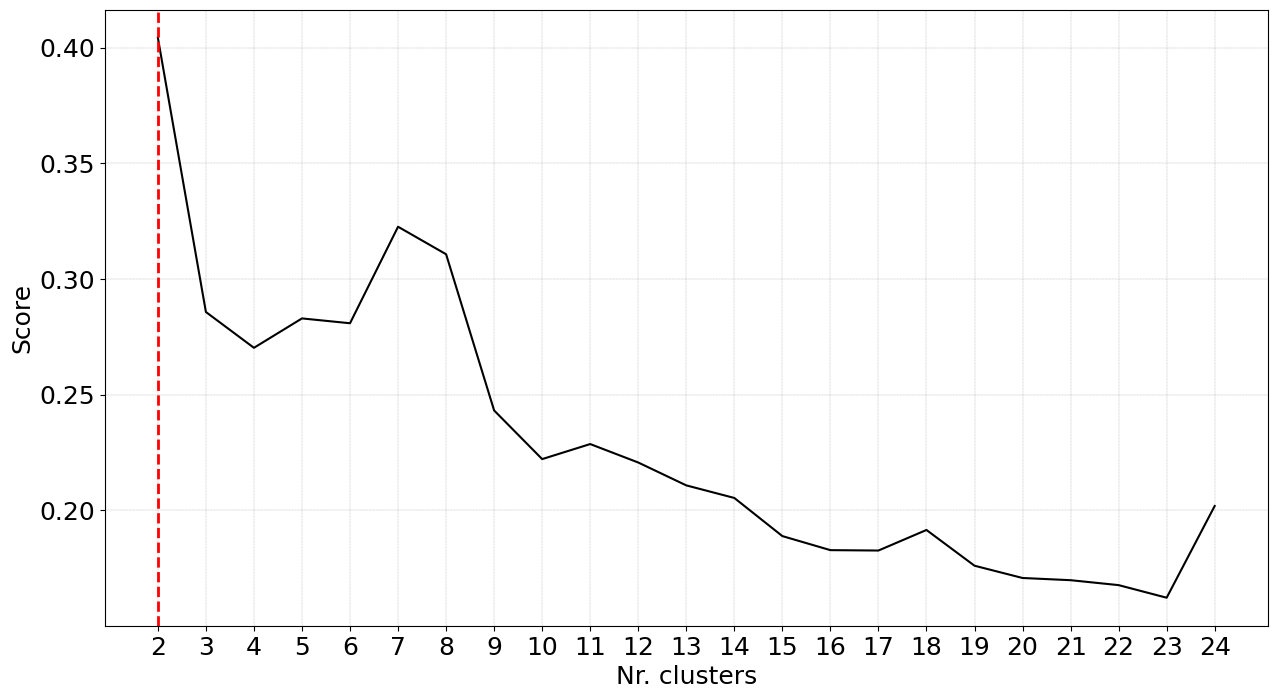

(<Figure size 1500x800 with 1 Axes>,
 <Axes: xlabel='Nr. clusters', ylabel='Score'>)

In [53]:
# Initialize
ce = clusteval(linkage= 'average',evaluate='silhouette')

# Fit
ce.fit(pca_df)

# Plot
ce.plot()

In [54]:
with open('results_pca/hierarchical/average_clustering.pickle', 'rb') as f:
    model_average = pickle.load(f)

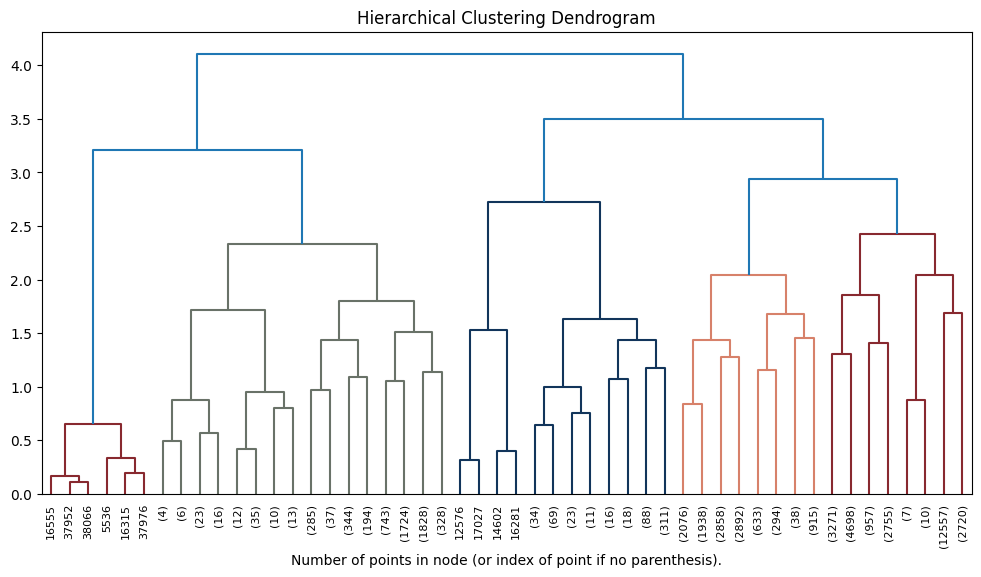

In [56]:
hierarchy.set_link_color_palette(my_colors)

plt.figure(figsize=(12, 6))
plt.title('Hierarchical Clustering Dendrogram')
# Plot the dendrogram
plot_dendrogram(model_average, truncate_mode='level', p = 5)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [57]:
# Cut dendrogram to obtain labels
num_clusters = 2  

# Convert the children_ attribute to a scipy hierarchical tree
linkage_matrix = np.column_stack([model_average.children_, model_average.distances_,
                                  np.ones_like(model_average.distances_)])
# Cut the tree to obtain labels
labels_cut_average = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

print(labels_cut_average)

[2 2 2 ... 2 2 2]


In [58]:
len(np.unique(labels_cut_average))

2

In [65]:
pca_df = pca_df.loc[:,'PC1':'PC2']
df_subset = df_subset.loc[:,'asset_id':'farm']

In [66]:
# Assign the cluster labels to the original DataFrame
pca_df['cluster_label'] = labels_cut_average
pca_df['asset_id'] = df_subset['asset_id']

In [67]:
df_subset['cluster_label'] = labels_cut_average

In [62]:
df_subset.to_csv('results_pca/hierarchical_opt/csv_labels_cut_raw/average_link.csv', index= False)

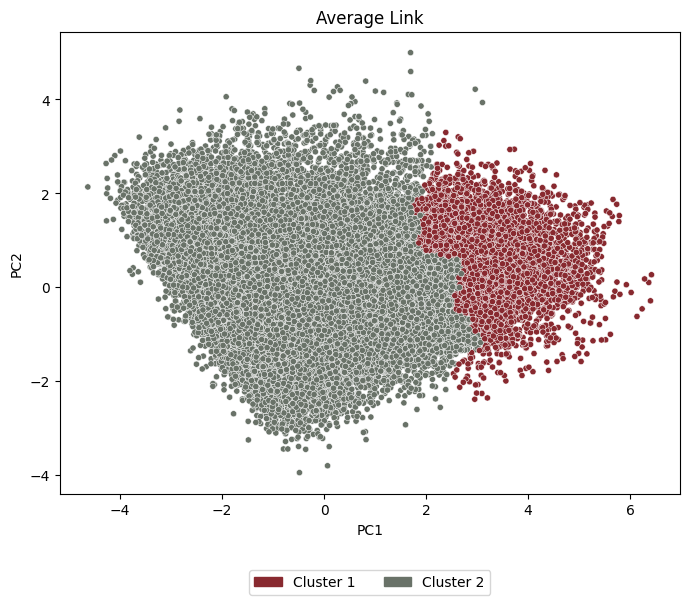

In [63]:
n_clusters = len(pca_df['cluster_label'].unique())
pallete = sns.color_palette(my_colors_2, n_clusters)

# Plot the representative points on a scatter plot using PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster_label', palette=pallete, s=20)
plt.title('Average Link')
plt.xlabel('PC1')
plt.ylabel('PC2')
legend_handles = [mpatches.Circle((0, 0), radius=1, color=color) for color in my_colors_2]
plt.legend(handles=legend_handles, labels=[f'Cluster {cluster_label}' for cluster_label in np.unique(labels_cut_average)],
           loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5)
plt.show()

In [68]:
most_frequent_clusters = pca_df.groupby('asset_id')['cluster_label'].agg(lambda x: np.bincount(x).argmax())

# Merge the most frequent cluster labels back to the original DataFrame
df_subset = df_subset.drop(columns='cluster_label')

df_subset = pd.merge(df_subset, most_frequent_clusters, on='asset_id', how='left')

df_subset.head()

,asset_id,read_at,wind_speed,wind_direction,power_average,rotation_average,exterior_temperature,nacelle_temperature,farm,cluster_label
0,11,1641199200,3.8,227.0,80.0,8.41,12.0,21.0,1,2
1,11,1614628200,5.2,231.0,165.0,9.93,5.0,20.0,1,2
2,11,1636269600,8.6,61.0,1013.0,16.26,7.0,12.0,1,2
3,11,1646093400,3.4,245.0,45.0,7.44,7.0,21.0,1,2
4,11,1613958000,7.0,271.0,571.0,14.35,0.0,12.0,1,2


In [69]:
len(most_frequent_clusters.unique())

1

In [72]:
# Merge the most frequent cluster labels back to the original DataFrame
pca_df = pca_df.drop(columns='cluster_label')

pca_df = pd.merge(pca_df, most_frequent_clusters, on='asset_id', how='left')

pca_df.head()

,PC1,PC2,asset_id,cluster_label
0,-1.253143,-0.763049,11,2
1,-0.374977,-1.197599,11,2
2,1.976068,-0.386187,11,2
3,-1.228114,-1.370854,11,2
4,1.454437,-1.465956,11,2


In [73]:
representative_points = pca_df.groupby(['asset_id']).first().reset_index()
representative_points

,asset_id,PC1,PC2,cluster_label
0,11,-1.253143,-0.763049,2
1,12,-3.048094,0.908466,2
2,13,-2.296033,-0.692692,2
3,14,4.322358,0.855529,2
4,15,-3.222389,1.460962,2
...,...,...,...,...
66,414,-1.996917,-1.151260,2
67,415,-0.195303,-1.531435,2
68,510,-1.418674,0.145497,2
69,511,1.187020,0.759987,2


In [74]:
assets_clusters = representative_points.groupby('cluster_label')['asset_id']

# Print assets in each cluster
for cluster, assets in assets_clusters:
    print(f"Cluster {cluster}: {assets.index.tolist()}")

Cluster 2: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70]


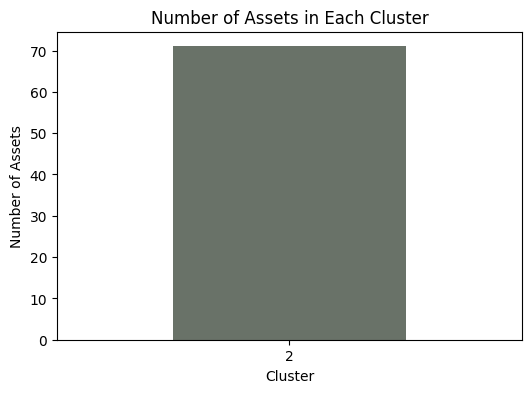

In [75]:
# Group assets by cluster and count the number of assets in each cluster
cluster_counts = representative_points['cluster_label'].value_counts().sort_index()

# Plot the number of assets in each cluster
plt.figure(figsize=(6, 4))
cluster_counts.plot(kind='bar', color=my_colors[1])
plt.xlabel('Cluster')
plt.ylabel('Number of Assets')
plt.title('Number of Assets in Each Cluster')
plt.xticks(rotation=0)
plt.show()

In [77]:
df_subset.to_csv('results_pca/hierarchical_opt/labels_most_common/average_link.csv', index= False)

In [78]:
df_subset = df_subset.loc[:,:'farm']
pca_df = pca_df.loc[:,:'PC2']

### Ward's method

[clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|██████████| 23/23 [08:43<00:00, 22.77s/it]
[clusteval] >INFO> Compute dendrogram threshold.
[clusteval] >INFO> Optimal number clusters detected: [2].
[clusteval] >INFO> Fin.


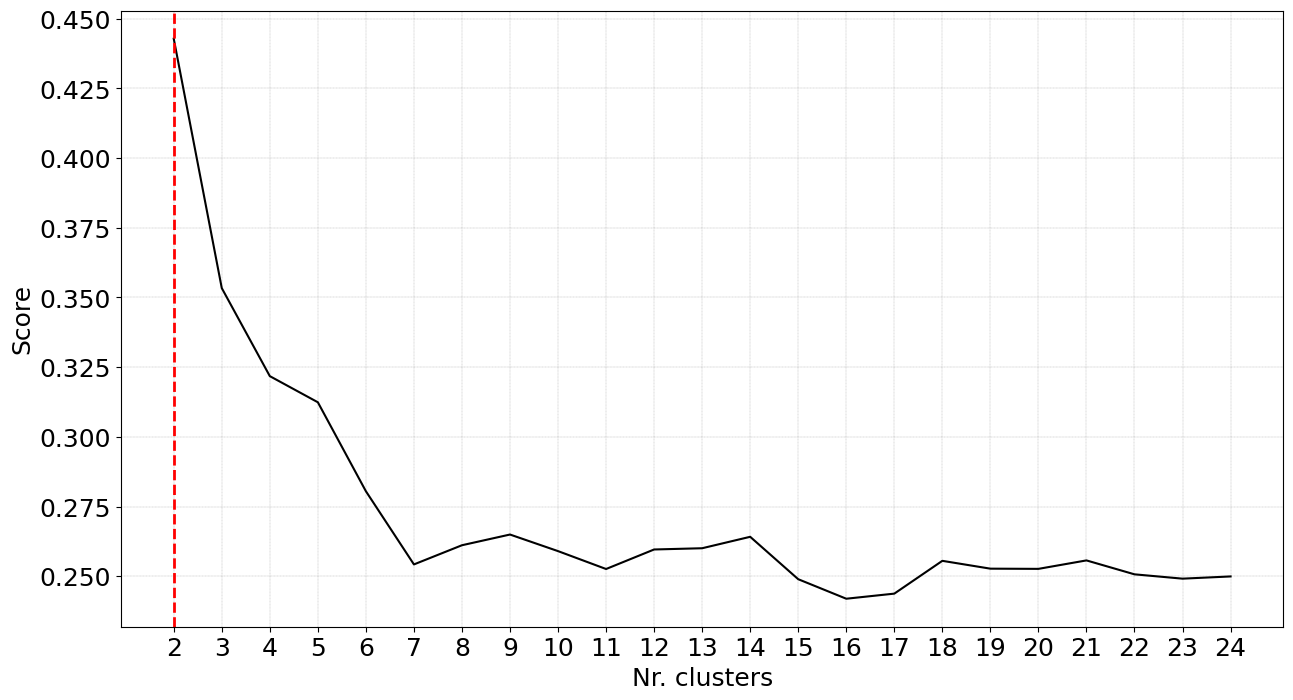

(<Figure size 1500x800 with 1 Axes>,
 <Axes: xlabel='Nr. clusters', ylabel='Score'>)

In [95]:
# Initialize
ce = clusteval(evaluate='silhouette')

# Fit
ce.fit(pca_df)

# Plot
ce.plot()

In [96]:
with open('results_pca/hierarchical/ward_clustering.pickle', 'rb') as f:
    model_ward = pickle.load(f)

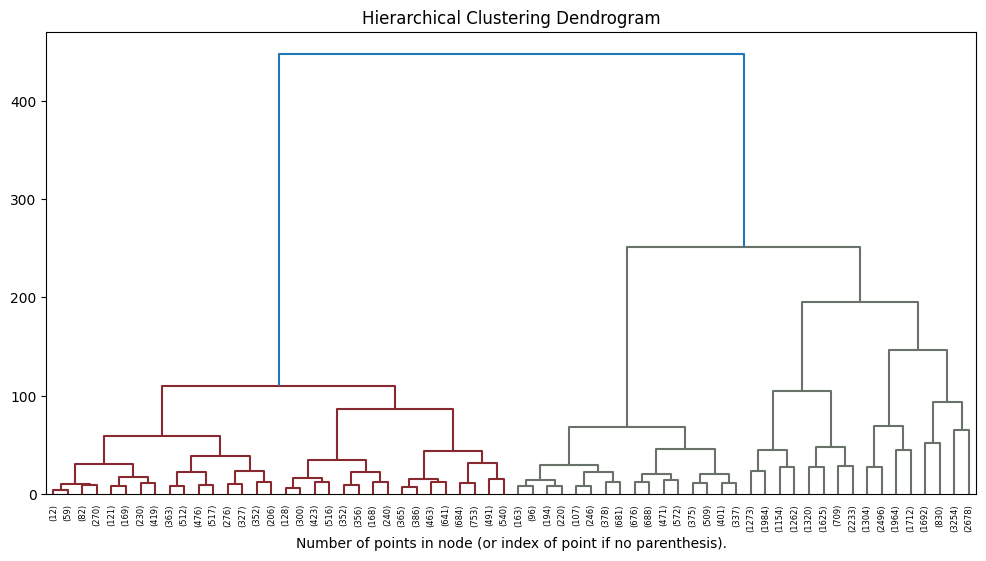

In [97]:
hierarchy.set_link_color_palette(my_colors)

plt.figure(figsize=(12, 6))
plt.title('Hierarchical Clustering Dendrogram')
# Plot the dendrogram
plot_dendrogram(model_ward, truncate_mode='level', p = 5)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [98]:
# Cut dendrogram to obtain labels
num_clusters = 2  

# Convert the children_ attribute to a scipy hierarchical tree
linkage_matrix = np.column_stack([model_ward.children_, model_ward.distances_,
                                  np.ones_like(model_ward.distances_)])
# Cut the tree to obtain labels
labels_cut_ward = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

print(labels_cut_ward)

[2 2 1 ... 1 1 2]


In [99]:
len(np.unique(labels_cut_ward))

2

In [100]:
pca_df = pca_df.loc[:,'PC1':'PC2']
df_subset = df_subset.loc[:,'asset_id':'farm']

In [101]:
# Assign the cluster labels to the original DataFrame
pca_df['cluster_label'] = labels_cut_ward
pca_df['asset_id'] = df_subset['asset_id']

In [102]:
df_subset['cluster_label'] = labels_cut_ward

In [103]:
df_subset.to_csv('results_pca/hierarchical_opt/csv_labels_cut_raw/ward_link.csv', index= False)

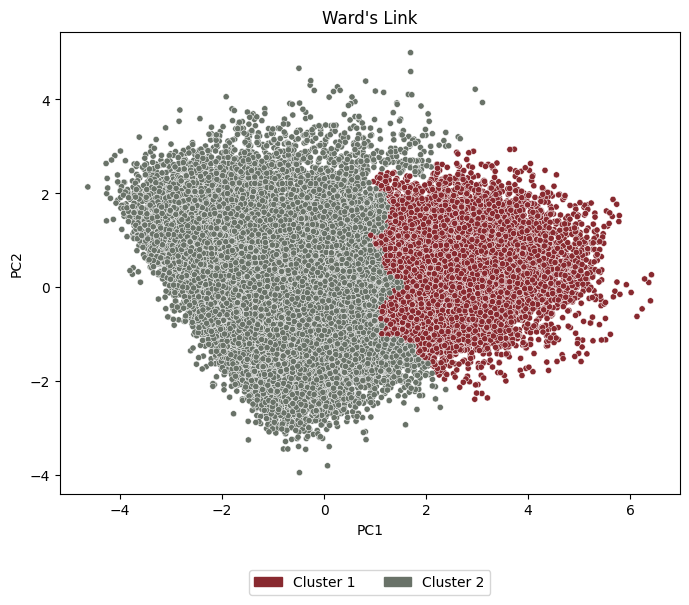

In [104]:
n_clusters = len(pca_df['cluster_label'].unique())
pallete = sns.color_palette(my_colors_2, n_clusters)

# Plot the representative points on a scatter plot using PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster_label', palette=pallete, s=20)
plt.title("Ward's Link")
plt.xlabel('PC1')
plt.ylabel('PC2')
legend_handles = [mpatches.Circle((0, 0), radius=1, color=color) for color in my_colors_2]
plt.legend(handles=legend_handles, labels=[f'Cluster {cluster_label}' for cluster_label in np.unique(labels_cut_ward)],
           loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5)
plt.show()

In [105]:
most_frequent_clusters = pca_df.groupby('asset_id')['cluster_label'].agg(lambda x: np.bincount(x).argmax())

# Merge the most frequent cluster labels back to the original DataFrame
df_subset = df_subset.drop(columns='cluster_label')

df_subset = pd.merge(df_subset, most_frequent_clusters, on='asset_id', how='left')

df_subset.head()

,asset_id,read_at,wind_speed,wind_direction,power_average,rotation_average,exterior_temperature,nacelle_temperature,farm,cluster_label
0,11,1641199200,3.8,227.0,80.0,8.41,12.0,21.0,1,2
1,11,1614628200,5.2,231.0,165.0,9.93,5.0,20.0,1,2
2,11,1636269600,8.6,61.0,1013.0,16.26,7.0,12.0,1,2
3,11,1646093400,3.4,245.0,45.0,7.44,7.0,21.0,1,2
4,11,1613958000,7.0,271.0,571.0,14.35,0.0,12.0,1,2


In [106]:
len(most_frequent_clusters.unique())

1

In [107]:
# Merge the most frequent cluster labels back to the original DataFrame
pca_df = pca_df.drop(columns='cluster_label')

pca_df = pd.merge(pca_df, most_frequent_clusters, on='asset_id', how='left')

pca_df.head()

,PC1,PC2,asset_id,cluster_label
0,-1.253143,-0.763049,11,2
1,-0.374977,-1.197599,11,2
2,1.976068,-0.386187,11,2
3,-1.228114,-1.370854,11,2
4,1.454437,-1.465956,11,2


In [108]:
representative_points = pca_df.groupby(['asset_id']).first().reset_index()
representative_points

,asset_id,PC1,PC2,cluster_label
0,11,-1.253143,-0.763049,2
1,12,-3.048094,0.908466,2
2,13,-2.296033,-0.692692,2
3,14,4.322358,0.855529,2
4,15,-3.222389,1.460962,2
...,...,...,...,...
66,414,-1.996917,-1.151260,2
67,415,-0.195303,-1.531435,2
68,510,-1.418674,0.145497,2
69,511,1.187020,0.759987,2


In [109]:
assets_clusters = representative_points.groupby('cluster_label')['asset_id']

# Print assets in each cluster
for cluster, assets in assets_clusters:
    print(f"Cluster {cluster}: {assets.index.tolist()}")

Cluster 2: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70]


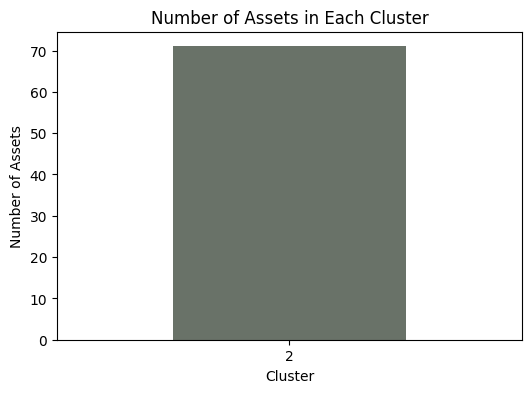

In [110]:
# Group assets by cluster and count the number of assets in each cluster
cluster_counts = representative_points['cluster_label'].value_counts().sort_index()

# Plot the number of assets in each cluster
plt.figure(figsize=(6, 4))
cluster_counts.plot(kind='bar', color=my_colors[1])
plt.xlabel('Cluster')
plt.ylabel('Number of Assets')
plt.title('Number of Assets in Each Cluster')
plt.xticks(rotation=0)
plt.show()

In [111]:
df_subset.to_csv('results_pca/hierarchical_opt/labels_most_common/ward_link.csv', index= False)

In [112]:
df_subset = df_subset.loc[:,:'farm']
pca_df = pca_df.loc[:,:'PC2']

### Centroid Linkage

[clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[centroid]
[clusteval] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|██████████| 23/23 [09:01<00:00, 23.52s/it]
[clusteval] >INFO> Compute dendrogram threshold.
[clusteval] >INFO> Optimal number clusters detected: [2].
[clusteval] >INFO> Fin.


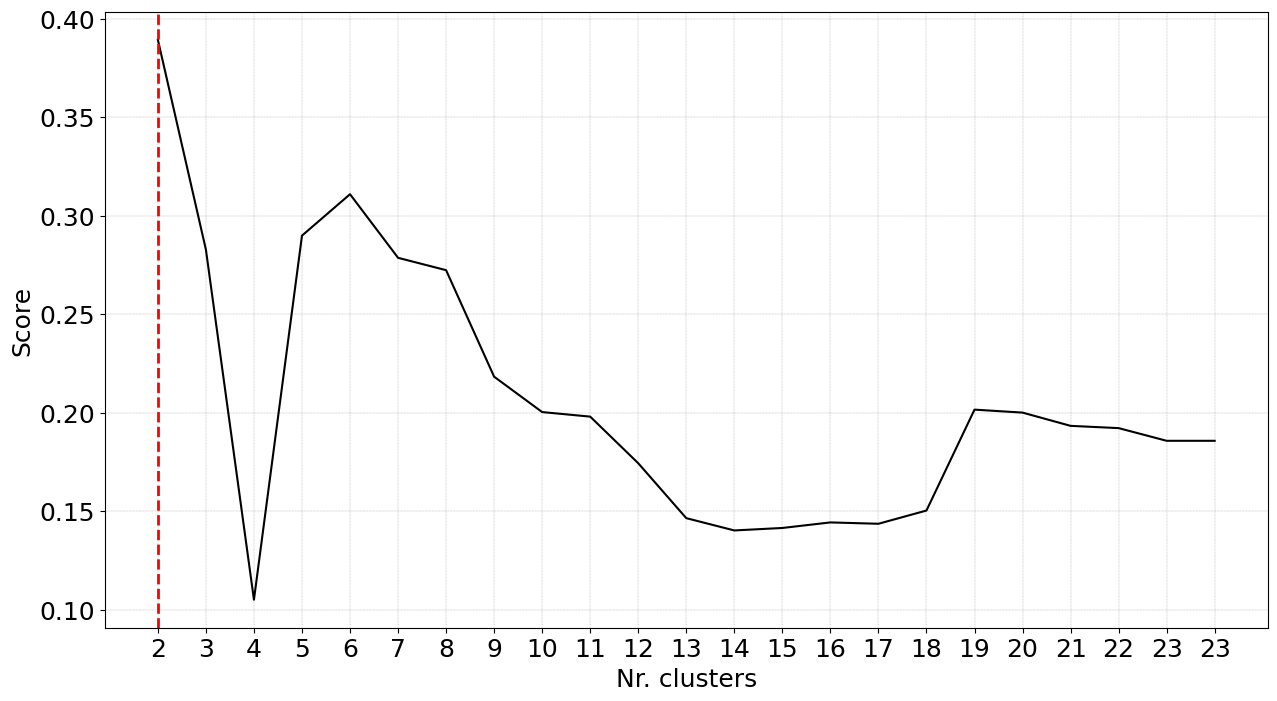

(<Figure size 1500x800 with 1 Axes>,
 <Axes: xlabel='Nr. clusters', ylabel='Score'>)

In [114]:
# Initialize
ce = clusteval(evaluate='silhouette', linkage='centroid')

# Fit
ce.fit(pca_df)

# Plot
ce.plot()

In [138]:
with open('results_pca/hierarchical/centroid_clustering.pickle', 'rb') as f:
    model_centroid = pickle.load(f)

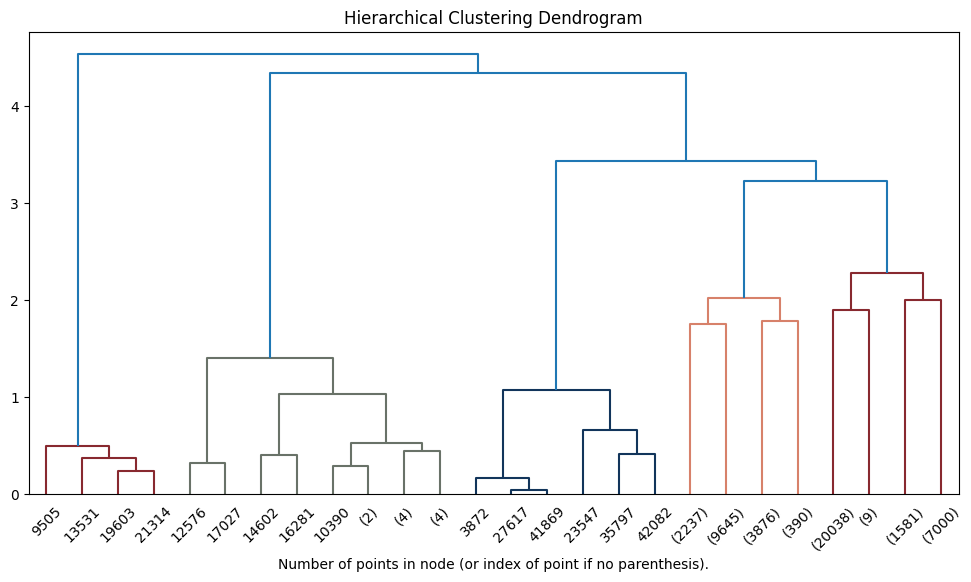

In [130]:
hierarchy.set_link_color_palette(my_colors)

plt.figure(figsize=(12, 6))
plt.title('Hierarchical Clustering Dendrogram')
# Plot the dendrogram
dendrogram(model_centroid, truncate_mode='level', p = 5)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [139]:
# Cut dendrogram to obtain labels
num_clusters = 2  

# Cut the tree to obtain labels
labels_cut_centroid = fcluster(model_centroid, num_clusters, criterion='maxclust')

print(labels_cut_centroid)

[2 2 2 ... 2 2 2]


In [140]:
len(np.unique(labels_cut_centroid))

2

In [141]:
pca_df = pca_df.loc[:,'PC1':'PC2']
df_subset = df_subset.loc[:,'asset_id':'farm']

In [142]:
# Assign the cluster labels to the original DataFrame
pca_df['cluster_label'] = labels_cut_centroid
pca_df['asset_id'] = df_subset['asset_id']

In [143]:
df_subset['cluster_label'] = labels_cut_centroid

In [144]:
df_subset.to_csv('results_pca/hierarchical_opt/csv_labels_cut_raw/centroid_link.csv', index= False)

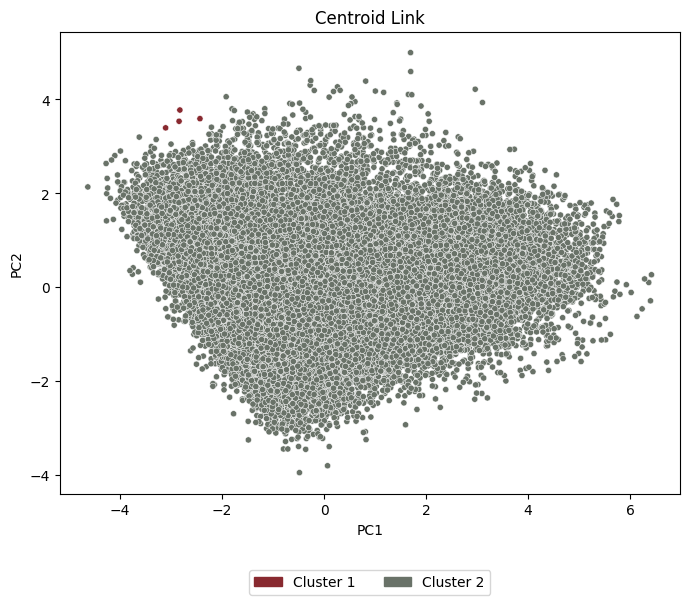

In [145]:
n_clusters = len(pca_df['cluster_label'].unique())
pallete = sns.color_palette(my_colors_2, n_clusters)

# Plot the representative points on a scatter plot using PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster_label', palette=pallete, s=20)
plt.title("Centroid Link")
plt.xlabel('PC1')
plt.ylabel('PC2')
legend_handles = [mpatches.Circle((0, 0), radius=1, color=color) for color in my_colors_2]
plt.legend(handles=legend_handles, labels=[f'Cluster {cluster_label}' for cluster_label in np.unique(labels_cut_centroid)],
           loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5)
plt.show()

In [146]:
most_frequent_clusters = pca_df.groupby('asset_id')['cluster_label'].agg(lambda x: np.bincount(x).argmax())

# Merge the most frequent cluster labels back to the original DataFrame
df_subset = df_subset.drop(columns='cluster_label')

df_subset = pd.merge(df_subset, most_frequent_clusters, on='asset_id', how='left')

df_subset.head()

,asset_id,read_at,wind_speed,wind_direction,power_average,rotation_average,exterior_temperature,nacelle_temperature,farm,cluster_label
0,11,1641199200,3.8,227.0,80.0,8.41,12.0,21.0,1,2
1,11,1614628200,5.2,231.0,165.0,9.93,5.0,20.0,1,2
2,11,1636269600,8.6,61.0,1013.0,16.26,7.0,12.0,1,2
3,11,1646093400,3.4,245.0,45.0,7.44,7.0,21.0,1,2
4,11,1613958000,7.0,271.0,571.0,14.35,0.0,12.0,1,2


In [147]:
len(most_frequent_clusters.unique())

1

In [148]:
# Merge the most frequent cluster labels back to the original DataFrame
pca_df = pca_df.drop(columns='cluster_label')

pca_df = pd.merge(pca_df, most_frequent_clusters, on='asset_id', how='left')

pca_df.head()

,PC1,PC2,asset_id,cluster_label
0,-1.253143,-0.763049,11,2
1,-0.374977,-1.197599,11,2
2,1.976068,-0.386187,11,2
3,-1.228114,-1.370854,11,2
4,1.454437,-1.465956,11,2


In [149]:
representative_points = pca_df.groupby(['asset_id']).first().reset_index()
representative_points

,asset_id,PC1,PC2,cluster_label
0,11,-1.253143,-0.763049,2
1,12,-3.048094,0.908466,2
2,13,-2.296033,-0.692692,2
3,14,4.322358,0.855529,2
4,15,-3.222389,1.460962,2
...,...,...,...,...
66,414,-1.996917,-1.151260,2
67,415,-0.195303,-1.531435,2
68,510,-1.418674,0.145497,2
69,511,1.187020,0.759987,2


In [150]:
assets_clusters = representative_points.groupby('cluster_label')['asset_id']

# Print assets in each cluster
for cluster, assets in assets_clusters:
    print(f"Cluster {cluster}: {assets.index.tolist()}")

Cluster 2: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70]


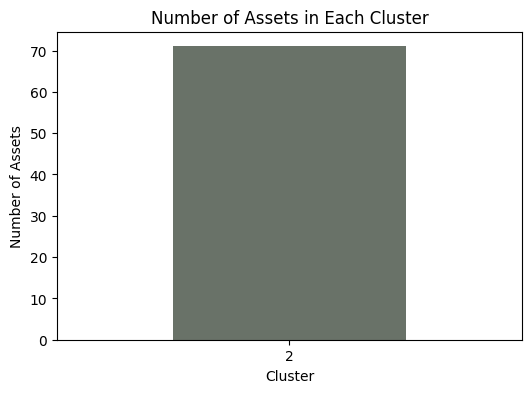

In [151]:
# Group assets by cluster and count the number of assets in each cluster
cluster_counts = representative_points['cluster_label'].value_counts().sort_index()

# Plot the number of assets in each cluster
plt.figure(figsize=(6, 4))
cluster_counts.plot(kind='bar', color=my_colors[1])
plt.xlabel('Cluster')
plt.ylabel('Number of Assets')
plt.title('Number of Assets in Each Cluster')
plt.xticks(rotation=0)
plt.show()

In [152]:
df_subset.to_csv('results_pca/hierarchical_opt/labels_most_common/centroid_link.csv', index= False)

In [153]:
df_subset = df_subset.loc[:,:'farm']
pca_df = pca_df.loc[:,:'PC2']